In [1]:
# import packages that will be used for plotting and analyzing the data

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import stats
%matplotlib inline

from sklearn.metrics import mean_squared_log_error

from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer, RobustScaler


In [58]:
df = pd.read_csv('Data/train_imputed.csv')

In [59]:
X = df.drop('SalePrice', axis=1)
y = df.SalePrice

In [60]:
X.head()

,MSSubClass,LotFrontage,LotArea,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,3,0,7,5,2003,2003,196.0,...,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,3,0,6,8,1976,1976,0.0,...,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,2,0,7,5,2001,2002,162.0,...,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,2,0,7,5,1915,1970,0.0,...,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,2,0,8,5,2000,2000,350.0,...,0,0,0,1,0,0,0,0,1,0


In [108]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# Linear Regression with PCA

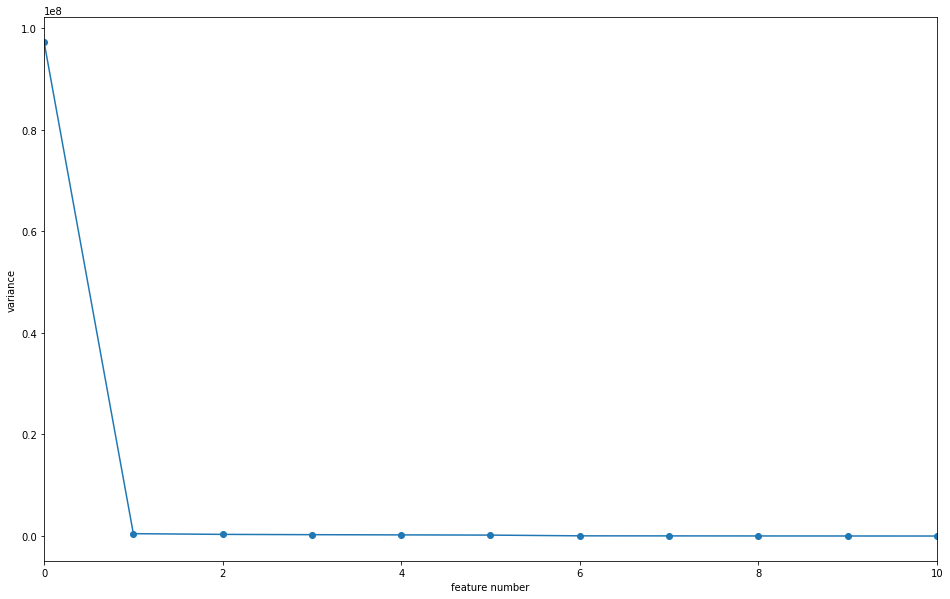

In [61]:
pca = PCA()
pca.fit(X)
features = range(pca.n_components_)
plt.figure(figsize=(16, 10))
plt.plot(features, pca.explained_variance_, '-o')

plt.xlabel('feature number')
plt.ylabel('variance')
plt.xlim(0, 10)
plt.show()

In [63]:
model=PCA(n_components=1)
model.fit(X)
df_components = pd.DataFrame(model.transform(X))
df_components.columns = ['component1']

In [64]:
df_PCA = df_components.join(y, how='left')

X_train, X_test, y_train, y_test = train_test_split(df_components, y, test_size=0.3, random_state=10)


In [65]:
reg_PCA = LinearRegression()
reg_PCA.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [66]:
reg.score(X_train, y_train)


0.071536663200562733

In [67]:
param_grid = {'fit_intercept':[True, False], 'normalize':[True, False]}

In [68]:
reg_cv = GridSearchCV(reg, param_grid, cv=5)
reg_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'fit_intercept': [True, False], 'normalize': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [69]:
print("Tuned Regression Parameter: {}".format(reg_cv.best_params_))
print("Tuned Regression Accuracy: {}".format(reg_cv.best_score_))

Tuned Regression Parameter: {'fit_intercept': True, 'normalize': False}
Tuned Regression Accuracy: 0.06309087925394023


In [92]:
y_pred_PCA = reg_cv.predict(X_test)

rmsle(y_test, y_pred_PCA)

ValueError: shapes (438,138) and (1,) not aligned: 138 (dim 1) != 1 (dim 0)

# Linear Regression (out of box)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)



In [74]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [76]:
reg.score(X_train, y_train)

0.93195435558885431

In [77]:
y_pred_reg = reg.predict(X_test)

mean_squared_log_error(y_test, y_pred_reg)

0.037353596115682994

# Linear Regression with VIF

def calculate_vif(X, thresh=5.0):
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropped {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X
        
calculate_vif(X)

In [79]:
# from https://www.kaggle.com/ffisegydd/sklearn-multicollinearity-class/code

class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=5.0, impute=True, impute_strategy='median'):
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.
        if impute:
            self.imputer = Imputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=5.0):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

In [80]:
transformer = ReduceVIF()
X = transformer.fit_transform(X, y)

ReduceVIF fit
ReduceVIF transform


C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\statsmodels\stats\outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\statsmodels\regression\linear_model.py:1386: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Dropping BsmtFinSF1 with vif=inf
Dropping 1stFlrSF with vif=inf
Dropping MSZoning_C (all) with vif=inf
Dropping MSZoning_FV with vif=inf
Dropping MSZoning_RH with vif=inf
Dropping MSZoning_RL with vif=inf
Dropping MSZoning_RM with vif=inf
Dropping Street_Grvl with vif=inf
Dropping Alley_Grvl with vif=inf
Dropping LandContour_Bnk with vif=inf
Dropping Utilities_AllPub with vif=inf
Dropping LotConfig_Corner with vif=inf
Dropping Neighborhood_Blmngtn with vif=inf
Dropping Condition1_Artery with vif=inf
Dropping Condition2_Artery with vif=inf
Dropping BldgType_1Fam with vif=inf
Dropping HouseStyle_1.5Fin with vif=inf
Dropping RoofStyle_Flat with vif=inf
Dropping RoofMatl_CompShg with vif=inf
Dropping Exterior1st_AsbShng with vif=inf
Dropping Exterior1st_CBlock with vif=inf
Dropping Exterior2nd_AsbShng with vif=inf
Dropping MasVnrType_BrkCmn with vif=inf
Dropping Foundation_BrkTil with vif=inf
Dropping Heating_Floor with vif=inf
Dropping Electrical_C (all) with vif=inf
Dropping GarageType_2

C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\statsmodels\regression\linear_model.py:1388: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Dropping YrSold with vif=107936.87267922967
Dropping YearBuilt with vif=41350.357198712394
Dropping GarageYrBlt with vif=25541.63859314166
Dropping YearRemodAdd with vif=16586.198363510255
Dropping MiscFeature_None with vif=4690.908755522898
Dropping Heating_GasA with vif=1214.9290243614744
Dropping Condition2_Norm with vif=750.150798846286
Dropping RoofStyle_Gable with vif=507.77679573190903
Dropping Street_Pave with vif=340.84799761950774
Dropping GarageCond with vif=324.50705308189475
Dropping GrLivArea with vif=187.85206696499716
Dropping GarageQual with vif=186.04066952304632
Dropping Electrical_RL with vif=172.54226871823627
Dropping Exterior1st_VinylSd with vif=162.69600100254928
Dropping GarageType_Attchd with vif=143.12239096356848
Dropping ExterQual with vif=134.34911880574555
Dropping Functional with vif=129.22093790519662
Dropping ExterCond with vif=109.09137123159228
Dropping OverallQual with vif=96.802074631713
Dropping BsmtCond with vif=95.89777542084066
Dropping TotRmsA

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)


In [84]:
reg_VIF = LinearRegression()
reg_VIF.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [86]:
reg_VIF.score(X_train, y_train)

0.81944211620960794

In [112]:
y_pred_reg_VIF = reg_VIF.predict(X_test)

rmsle(y_test, y_pred_reg_VIF)

0.41924826806113458

In [19]:
reg_cv = GridSearchCV(reg, param_grid, cv=5)
reg_cv.fit(X,y)

print("Tuned Logistic Regression Parameter: {}".format(reg_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(reg_cv.best_score_))

Tuned Logistic Regression Parameter: {'fit_intercept': True, 'normalize': False}
Tuned Logistic Regression Accuracy: -605390300.4302213


# Lasso Regression

In [101]:
X_scaled = pd.DataFrame(RobustScaler().fit_transform(X))
X_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,128,129,130,131,132,133,134,135,136,137
0,-0.252743,0.0,1.196947,0.0,-0.559829,0.0,1.0,0.0,1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.030822,0.0,0.000000,0.0,-0.330769,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.437677,0.0,0.989313,0.0,-0.074359,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.018493,0.0,0.000000,0.0,0.106838,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.179879,0.0,2.137405,0.0,0.021368,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=10)


In [105]:
reg_lasso = Lasso()
reg_lasso.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [111]:
y_pred_reg_lasso = reg_lasso.predict(X_test)

rmsle(y_test, y_pred_reg_lasso)

0.22766692250875895

# Random Forest

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [117]:
reg_rf = RandomForestClassifier()
reg_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [118]:
y_pred_reg_rf = reg_rf.predict(X_test)

rmsle(y_test, y_pred_reg_rf)

0.36859974822003694

In [21]:
# Specify the hyperparameters to be tested with RandomizedSearchCV

# Number of trees in random forest
n_estimators = [120, 300, 500, 800, 1200]

# Number of features to consider at every split
max_features = ['Log2', 'sqrt', None]

# Maximum number of levels in tree
max_depth = [5, 8, 15, 25, 30, None]

# Minimum number of samples required to split a node
min_samples_split = [1, 2, 5, 10, 15, 100]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_cv = GridSearchCV(rf, param_grid, cv=5)
rf_cv.fit(X, y)

In [35]:
# Use the random grid to search for best hyperparameters

# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=10, n_jobs = -1)

# Fit the random search model
rf_random.fit(X, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...Py36\\lib\\site-packages\\ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\runpy.py in _run_code(code=<code object <module> at 0x0000000002057810, fil...lib\site-packages\ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\wongk3.NA\AppData\Local\Continuum\Anaco...ges\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\wongk3.NA\AppData\Local\Continuum\Anaco...s\newPy36\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...Py36\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\w...36\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...Py36\\lib\\site-packages\\ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x0000000002057810, fil...lib\site-packages\ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\wongk3.NA\AppData\Local\Continuum\Anaco...ges\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\wongk3.NA\AppData\Local\Continuum\Anaco...s\newPy36\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...Py36\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\w...36\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\zmq\eventloop\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\tornado\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': '# Use the random grid to search for best hyperpa...# Fit the random search model\nrf_random.fit(X, y)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 5, 15, 0, 13, 49, 665337, tzinfo=datetime.timezone.utc), 'msg_id': 'BC085BF391534D0D81ADC1A9E3F55149', 'msg_type': 'execute_request', 'session': 'AAE66A19F0144F0086F54BCE87F250EF', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'BC085BF391534D0D81ADC1A9E3F55149', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'AAE66A19F0144F0086F54BCE87F250EF']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': '# Use the random grid to search for best hyperpa...# Fit the random search model\nrf_random.fit(X, y)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 5, 15, 0, 13, 49, 665337, tzinfo=datetime.timezone.utc), 'msg_id': 'BC085BF391534D0D81ADC1A9E3F55149', 'msg_type': 'execute_request', 'session': 'AAE66A19F0144F0086F54BCE87F250EF', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'BC085BF391534D0D81ADC1A9E3F55149', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'AAE66A19F0144F0086F54BCE87F250EF'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': '# Use the random grid to search for best hyperpa...# Fit the random search model\nrf_random.fit(X, y)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 5, 15, 0, 13, 49, 665337, tzinfo=datetime.timezone.utc), 'msg_id': 'BC085BF391534D0D81ADC1A9E3F55149', 'msg_type': 'execute_request', 'session': 'AAE66A19F0144F0086F54BCE87F250EF', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'BC085BF391534D0D81ADC1A9E3F55149', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='# Use the random grid to search for best hyperpa...# Fit the random search model\nrf_random.fit(X, y)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = '# Use the random grid to search for best hyperpa...# Fit the random search model\nrf_random.fit(X, y)'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('# Use the random grid to search for best hyperpa...# Fit the random search model\nrf_random.fit(X, y)',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('# Use the random grid to search for best hyperpa...# Fit the random search model\nrf_random.fit(X, y)',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='# Use the random grid to search for best hyperpa...# Fit the random search model\nrf_random.fit(X, y)', store_history=True, silent=False, shell_futures=True)
   2693                 self.displayhook.exec_result = result
   2694 
   2695                 # Execute the user code
   2696                 interactivity = "none" if silent else self.ast_node_interactivity
   2697                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2698                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2699                 
   2700                 self.last_execution_succeeded = not has_raised
   2701 
   2702                 # Reset this so later displayed values do not modify the

...........................................................................
C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Expr object>], cell_name='<ipython-input-35-430f5c5e7da9>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at c87ee80, execution_co..._before_exec=None error_in_exec=None result=None>)
   2803                     return True
   2804 
   2805             for i, node in enumerate(to_run_interactive):
   2806                 mod = ast.Interactive([node])
   2807                 code = compiler(mod, cell_name, "single")
-> 2808                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x000000000C8D8930, file "<ipython-input-35-430f5c5e7da9>", line 8>
        result = <ExecutionResult object at c87ee80, execution_co..._before_exec=None error_in_exec=None result=None>
   2809                     return True
   2810 
   2811             # Flush softspace
   2812             if softspace(sys.stdout, 0):

...........................................................................
C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x000000000C8D8930, file "<ipython-input-35-430f5c5e7da9>", line 8>, result=<ExecutionResult object at c87ee80, execution_co..._before_exec=None error_in_exec=None result=None>)
   2857         outflag = True  # happens in more places, so it's easier as default
   2858         try:
   2859             try:
   2860                 self.hooks.pre_run_code_hook()
   2861                 #rprint('Running code', repr(code_obj)) # dbg
-> 2862                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x000000000C8D8930, file "<ipython-input-35-430f5c5e7da9>", line 8>
        self.user_global_ns = {'BaseEstimator': <class 'sklearn.base.BaseEstimator'>, 'DummyClassifier': <class 'sklearn.dummy.DummyClassifier'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'Imputer': <class 'sklearn.preprocessing.imputation.Imputer'>, 'In': ['', '# import packages that will be used for plotting...tliers_influence import variance_inflation_factor', "df = pd.read_csv('Data/train_imputed.csv')\nX_test = pd.read_csv('Data/test.csv')", "X = df.drop('SalePrice', axis=1)\ny = df.SalePrice", "pca = PCA()\npca.fit(X)\nfeatures = range(pca.n_co...plt.ylabel('variance')\nplt.xlim(0, 10)\nplt.show()", "model=PCA(n_components=1)\nmodel.fit(X)\ndf_compon...nsform(X))\ndf_components.columns = ['component1']", "df_PCA = df_components.join(y, how='left')\n\nX_tr...df_components, y, test_size=0.3, random_state=10)", 'reg = LinearRegression()\nreg.fit(X_train, y_train)', 'reg.score(X_train, y_train)', "param_grid = {'fit_intercept':[True, False], 'normalize':[True, False]}", 'reg_cv = GridSearchCV(reg, param_grid, cv=5)\nreg_cv.fit(X_train, y_train)', 'print("Tuned Regression Parameter: {}".format(re...ression Accuracy: {}".format(reg_cv.best_score_))', 'reg2 = LinearRegression(fit_intercept=True, normalize=True)\nreg2.fit(df_components, y)', 'reg2.score(df_components, y)', 'reg = LinearRegression()\nreg.fit(X, y)', 'def calculate_vif(X, thresh=5.0):\n        droppe...=1)\n                dropped=True\n        return X', 'calculate_vif(X)', 'reg = LinearRegression()\nreg.fit(X, y)', 'reg.score(X, y)', 'reg_cv = GridSearchCV(reg, param_grid, cv=5)\nreg...ression Accuracy: {}".format(reg_cv.best_score_))', ...], 'LinearRegression': <class 'sklearn.linear_model.base.LinearRegression'>, 'Out': {7: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False), 8: 0.070036434041666484, 10: GridSearchCV(cv=5, error_score='raise',
       e...ain_score='warn',
       scoring=None, verbose=0), 12: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True), 13: 0.070282442428833525, 14: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False), 16:         Id  LotArea  LandSlope  MasVnrArea  Bsmt...                   0  

[1460 rows x 138 columns], 17: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False), 18: 0.91903460666993364, 20: 0.99863013698630132, ...}, 'PCA': <class 'sklearn.decomposition.pca.PCA'>, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'RandomizedSearchCV': <class 'sklearn.model_selection._search.RandomizedSearchCV'>, ...}
        self.user_ns = {'BaseEstimator': <class 'sklearn.base.BaseEstimator'>, 'DummyClassifier': <class 'sklearn.dummy.DummyClassifier'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'Imputer': <class 'sklearn.preprocessing.imputation.Imputer'>, 'In': ['', '# import packages that will be used for plotting...tliers_influence import variance_inflation_factor', "df = pd.read_csv('Data/train_imputed.csv')\nX_test = pd.read_csv('Data/test.csv')", "X = df.drop('SalePrice', axis=1)\ny = df.SalePrice", "pca = PCA()\npca.fit(X)\nfeatures = range(pca.n_co...plt.ylabel('variance')\nplt.xlim(0, 10)\nplt.show()", "model=PCA(n_components=1)\nmodel.fit(X)\ndf_compon...nsform(X))\ndf_components.columns = ['component1']", "df_PCA = df_components.join(y, how='left')\n\nX_tr...df_components, y, test_size=0.3, random_state=10)", 'reg = LinearRegression()\nreg.fit(X_train, y_train)', 'reg.score(X_train, y_train)', "param_grid = {'fit_intercept':[True, False], 'normalize':[True, False]}", 'reg_cv = GridSearchCV(reg, param_grid, cv=5)\nreg_cv.fit(X_train, y_train)', 'print("Tuned Regression Parameter: {}".format(re...ression Accuracy: {}".format(reg_cv.best_score_))', 'reg2 = LinearRegression(fit_intercept=True, normalize=True)\nreg2.fit(df_components, y)', 'reg2.score(df_components, y)', 'reg = LinearRegression()\nreg.fit(X, y)', 'def calculate_vif(X, thresh=5.0):\n        droppe...=1)\n                dropped=True\n        return X', 'calculate_vif(X)', 'reg = LinearRegression()\nreg.fit(X, y)', 'reg.score(X, y)', 'reg_cv = GridSearchCV(reg, param_grid, cv=5)\nreg...ression Accuracy: {}".format(reg_cv.best_score_))', ...], 'LinearRegression': <class 'sklearn.linear_model.base.LinearRegression'>, 'Out': {7: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False), 8: 0.070036434041666484, 10: GridSearchCV(cv=5, error_score='raise',
       e...ain_score='warn',
       scoring=None, verbose=0), 12: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True), 13: 0.070282442428833525, 14: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False), 16:         Id  LotArea  LandSlope  MasVnrArea  Bsmt...                   0  

[1460 rows x 138 columns], 17: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False), 18: 0.91903460666993364, 20: 0.99863013698630132, ...}, 'PCA': <class 'sklearn.decomposition.pca.PCA'>, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'RandomizedSearchCV': <class 'sklearn.model_selection._search.RandomizedSearchCV'>, ...}
   2863             finally:
   2864                 # Reset our crash handler in place
   2865                 sys.excepthook = old_excepthook
   2866         except SystemExit as e:

...........................................................................
C:\Users\wongk3.NA\Desktop\Springboard\Capstone_2\<ipython-input-35-430f5c5e7da9> in <module>()
      3 # Random search of parameters, using 5 fold cross validation, 
      4 # search across 100 different combinations, and use all available cores
      5 rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=10, n_jobs = -1)
      6 
      7 # Fit the random search model
----> 8 rf_random.fit(X, y)

...........................................................................
C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\sklearn\model_selection\_search.py in fit(self=RandomizedSearchCV(cv=5, error_score='raise',
  ...turn_train_score='warn', scoring=None, verbose=2), X=          Id  LotArea  LandSlope  MasVnrArea  Bs...                 0.0  

[1460 rows x 138 columns], y=0       208500
1       181500
2       223500
3  ...47500
Name: SalePrice, Length: 1460, dtype: int64, groups=None, **fit_params={})
    634                                   return_train_score=self.return_train_score,
    635                                   return_n_test_samples=True,
    636                                   return_times=True, return_parameters=False,
    637                                   error_score=self.error_score)
    638           for parameters, (train, test) in product(candidate_params,
--> 639                                                    cv.split(X, y, groups)))
        cv.split = <bound method StratifiedKFold.split of Stratifie...ld(n_splits=5, random_state=None, shuffle=False)>
        X =           Id  LotArea  LandSlope  MasVnrArea  Bs...                 0.0  

[1460 rows x 138 columns]
        y = 0       208500
1       181500
2       223500
3  ...47500
Name: SalePrice, Length: 1460, dtype: int64
        groups = None
    640 
    641         # if one choose to see train score, "out" will contain train score info
    642         if self.return_train_score:
    643             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Mon May 14 17:14:13 2018
PID: 3280Python 3.6.3: C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\python.exe
...........................................................................
C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False),           Id  LotArea  LandSlope  MasVnrArea  Bs...                 0.0  

[1460 rows x 138 columns], 0       208500
1       181500
2       223500
3  ...47500
Name: SalePrice, Length: 1460, dtype: int64, {'score': <function _passthrough_scorer>}, array([  23,   71,  120,  130,  131,  134,  149,...1448, 1450, 1452, 1453, 1454,
       1455, 1456]), array([   0,    1,    2,    3,    4,    5,    6,...1443,
       1444, 1449, 1451, 1457, 1458, 1459]), 2, {'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 120}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False),           Id  LotArea  LandSlope  MasVnrArea  Bs...                 0.0  

[1460 rows x 138 columns], 0       208500
1       181500
2       223500
3  ...47500
Name: SalePrice, Length: 1460, dtype: int64, {'score': <function _passthrough_scorer>}, array([  23,   71,  120,  130,  131,  134,  149,...1448, 1450, 1452, 1453, 1454,
       1455, 1456]), array([   0,    1,    2,    3,    4,    5,    6,...1443,
       1444, 1449, 1451, 1457, 1458, 1459]), 2, {'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 120})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\sklearn\model_selection\_validation.py in _fit_and_score(estimator=RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), X=          Id  LotArea  LandSlope  MasVnrArea  Bs...                 0.0  

[1460 rows x 138 columns], y=0       208500
1       181500
2       223500
3  ...47500
Name: SalePrice, Length: 1460, dtype: int64, scorer={'score': <function _passthrough_scorer>}, train=array([  23,   71,  120,  130,  131,  134,  149,...1448, 1450, 1452, 1453, 1454,
       1455, 1456]), test=array([   0,    1,    2,    3,    4,    5,    6,...1443,
       1444, 1449, 1451, 1457, 1458, 1459]), verbose=2, parameters={'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 120}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    453 
    454     try:
    455         if y_train is None:
    456             estimator.fit(X_train, **fit_params)
    457         else:
--> 458             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method BaseForest.fit of RandomForestClas...e=None, verbose=0,
            warm_start=False)>
        X_train =           Id   LotArea  LandSlope  MasVnrArea  B...                  0.0  

[728 rows x 138 columns]
        y_train = 23      129900
71      129500
120     180000
130...210000
Name: SalePrice, Length: 728, dtype: int64
        fit_params = {}
    459 
    460     except Exception as e:
    461         # Note fit time as time until error
    462         fit_time = time.time() - start_time

...........................................................................
C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\sklearn\ensemble\forest.py in fit(self=RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), X=array([[  2.40000000e+01,   4.22400000e+03,   0.....00000000e+00,   0.00000000e+00]], dtype=float32), y=array([[  69.],
       [  68.],
       [ 157.],
...
       [ 161.],
       [ 146.],
       [ 192.]]), sample_weight=None)
    323             trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
    324                              backend="threading")(
    325                 delayed(_parallel_build_trees)(
    326                     t, self, X, y, sample_weight, i, len(trees),
    327                     verbose=self.verbose, class_weight=self.class_weight)
--> 328                 for i, t in enumerate(trees))
        i = 119
    329 
    330             # Collect newly grown trees
    331             self.estimators_.extend(trees)
    332 

...........................................................................
C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=1), iterable=<generator object BaseForest.fit.<locals>.<genexpr>>)
    774         self.n_completed_tasks = 0
    775         try:
    776             # Only set self._iterating to True if at least a batch
    777             # was dispatched. In particular this covers the edge
    778             # case of Parallel used with an exhausted iterator.
--> 779             while self.dispatch_one_batch(iterator):
        self.dispatch_one_batch = <bound method Parallel.dispatch_one_batch of Parallel(n_jobs=1)>
        iterator = <generator object BaseForest.fit.<locals>.<genexpr>>
    780                 self._iterating = True
    781             else:
    782                 self._iterating = False
    783 

...........................................................................
C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\sklearn\externals\joblib\parallel.py in dispatch_one_batch(self=Parallel(n_jobs=1), iterator=<generator object BaseForest.fit.<locals>.<genexpr>>)
    620             tasks = BatchedCalls(itertools.islice(iterator, batch_size))
    621             if len(tasks) == 0:
    622                 # No more tasks available in the iterator: tell caller to stop.
    623                 return False
    624             else:
--> 625                 self._dispatch(tasks)
        self._dispatch = <bound method Parallel._dispatch of Parallel(n_jobs=1)>
        tasks = <sklearn.externals.joblib.parallel.BatchedCalls object>
    626                 return True
    627 
    628     def _print(self, msg, msg_args):
    629         """Display the message on stout or stderr depending on verbosity"""

...........................................................................
C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\sklearn\externals\joblib\parallel.py in _dispatch(self=Parallel(n_jobs=1), batch=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    583         self.n_dispatched_tasks += len(batch)
    584         self.n_dispatched_batches += 1
    585 
    586         dispatch_timestamp = time.time()
    587         cb = BatchCompletionCallBack(dispatch_timestamp, len(batch), self)
--> 588         job = self._backend.apply_async(batch, callback=cb)
        job = undefined
        self._backend.apply_async = <bound method SequentialBackend.apply_async of <...lib._parallel_backends.SequentialBackend object>>
        batch = <sklearn.externals.joblib.parallel.BatchedCalls object>
        cb = <sklearn.externals.joblib.parallel.BatchCompletionCallBack object>
    589         self._jobs.append(job)
    590 
    591     def dispatch_next(self):
    592         """Dispatch more data for parallel processing

...........................................................................
C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\sklearn\externals\joblib\_parallel_backends.py in apply_async(self=<sklearn.externals.joblib._parallel_backends.SequentialBackend object>, func=<sklearn.externals.joblib.parallel.BatchedCalls object>, callback=<sklearn.externals.joblib.parallel.BatchCompletionCallBack object>)
    106             raise ValueError('n_jobs == 0 in Parallel has no meaning')
    107         return 1
    108 
    109     def apply_async(self, func, callback=None):
    110         """Schedule a func to be run"""
--> 111         result = ImmediateResult(func)
        result = undefined
        func = <sklearn.externals.joblib.parallel.BatchedCalls object>
    112         if callback:
    113             callback(result)
    114         return result
    115 

...........................................................................
C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\sklearn\externals\joblib\_parallel_backends.py in __init__(self=<sklearn.externals.joblib._parallel_backends.ImmediateResult object>, batch=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    327 
    328 class ImmediateResult(object):
    329     def __init__(self, batch):
    330         # Don't delay the application, to avoid keeping the input
    331         # arguments in memory
--> 332         self.results = batch()
        self.results = undefined
        batch = <sklearn.externals.joblib.parallel.BatchedCalls object>
    333 
    334     def get(self):
    335         return self.results
    336 

...........................................................................
C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _parallel_build_trees>, (DecisionTreeClassifier(class_weight=None, criter...         random_state=934923381, splitter='best'), RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), array([[  2.40000000e+01,   4.22400000e+03,   0.....00000000e+00,   0.00000000e+00]], dtype=float32), array([[  69.],
       [  68.],
       [ 157.],
...
       [ 161.],
       [ 146.],
       [ 192.]]), None, 0, 120), {'class_weight': None, 'verbose': 0})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _parallel_build_trees>
        args = (DecisionTreeClassifier(class_weight=None, criter...         random_state=934923381, splitter='best'), RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), array([[  2.40000000e+01,   4.22400000e+03,   0.....00000000e+00,   0.00000000e+00]], dtype=float32), array([[  69.],
       [  68.],
       [ 157.],
...
       [ 161.],
       [ 146.],
       [ 192.]]), None, 0, 120)
        kwargs = {'class_weight': None, 'verbose': 0}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\sklearn\ensemble\forest.py in _parallel_build_trees(tree=DecisionTreeClassifier(class_weight=None, criter...         random_state=934923381, splitter='best'), forest=RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), X=array([[  2.40000000e+01,   4.22400000e+03,   0.....00000000e+00,   0.00000000e+00]], dtype=float32), y=array([[  69.],
       [  68.],
       [ 157.],
...
       [ 161.],
       [ 146.],
       [ 192.]]), sample_weight=None, tree_idx=0, n_trees=120, verbose=0, class_weight=None)
    116                 warnings.simplefilter('ignore', DeprecationWarning)
    117                 curr_sample_weight *= compute_sample_weight('auto', y, indices)
    118         elif class_weight == 'balanced_subsample':
    119             curr_sample_weight *= compute_sample_weight('balanced', y, indices)
    120 
--> 121         tree.fit(X, y, sample_weight=curr_sample_weight, check_input=False)
        tree.fit = <bound method DecisionTreeClassifier.fit of Deci...        random_state=934923381, splitter='best')>
        X = array([[  2.40000000e+01,   4.22400000e+03,   0.....00000000e+00,   0.00000000e+00]], dtype=float32)
        y = array([[  69.],
       [  68.],
       [ 157.],
...
       [ 161.],
       [ 146.],
       [ 192.]])
        sample_weight = None
        curr_sample_weight = array([ 0.,  0.,  1.,  0.,  0.,  2.,  1.,  0.,  ...0.,  0.,  2.,  2.,  1.,  0.,  0.,  0.,  1.,  0.])
    122     else:
    123         tree.fit(X, y, sample_weight=sample_weight, check_input=False)
    124 
    125     return tree

...........................................................................
C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\sklearn\tree\tree.py in fit(self=DecisionTreeClassifier(class_weight=None, criter...         random_state=934923381, splitter='best'), X=array([[  2.40000000e+01,   4.22400000e+03,   0.....00000000e+00,   0.00000000e+00]], dtype=float32), y=array([[  69.],
       [  68.],
       [ 157.],
...
       [ 161.],
       [ 146.],
       [ 192.]]), sample_weight=array([ 0.,  0.,  1.,  0.,  0.,  2.,  1.,  0.,  ...0.,  0.,  2.,  2.,  1.,  0.,  0.,  0.,  1.,  0.]), check_input=False, X_idx_sorted=None)
    785 
    786         super(DecisionTreeClassifier, self).fit(
    787             X, y,
    788             sample_weight=sample_weight,
    789             check_input=check_input,
--> 790             X_idx_sorted=X_idx_sorted)
        X_idx_sorted = None
    791         return self
    792 
    793     def predict_proba(self, X, check_input=True):
    794         """Predict class probabilities of the input samples X.

...........................................................................
C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\sklearn\tree\tree.py in fit(self=DecisionTreeClassifier(class_weight=None, criter...         random_state=934923381, splitter='best'), X=array([[  2.40000000e+01,   4.22400000e+03,   0.....00000000e+00,   0.00000000e+00]], dtype=float32), y=array([[  69.],
       [  68.],
       [ 157.],
...
       [ 161.],
       [ 146.],
       [ 192.]]), sample_weight=array([ 0.,  0.,  1.,  0.,  0.,  2.,  1.,  0.,  ...0.,  0.,  2.,  2.,  1.,  0.,  0.,  0.,  1.,  0.]), check_input=False, X_idx_sorted=None)
    189         if isinstance(self.min_samples_split, (numbers.Integral, np.integer)):
    190             if not 2 <= self.min_samples_split:
    191                 raise ValueError("min_samples_split must be an integer "
    192                                  "greater than 1 or a float in (0.0, 1.0]; "
    193                                  "got the integer %s"
--> 194                                  % self.min_samples_split)
        self.min_samples_split = 1
    195             min_samples_split = self.min_samples_split
    196         else:  # float
    197             if not 0. < self.min_samples_split <= 1.:
    198                 raise ValueError("min_samples_split must be an integer "

ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1
___________________________________________________________________________

# XGBoost

In [2]:
reg_xgb = xgb.XGBRegressor()